<h1>Data Analysis</h1>
<h2>Data Generation</h2>
This page is for analysis of the data and analysis of the model. First, we'll look at the distributions of the different components of data generation. First, we'll load the imports and Data Generator before we plot the distributions of each data generator component. 

In [3]:
import math
import os
import torch
from torch.distributions import constraints
from matplotlib import pyplot

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.tracking.assignment import MarginalAssignmentPersistent
from pyro.distributions.util import gather
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
import numpy as np
import enum

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

assert pyro.__version__.startswith('1.7.0')

class MovementType(enum.Enum):
    Sinusoidal = 1
    Linear2D = 2
    Linear3D = 3

class Args:
    def __init__(self):
        self.args = self.get_default_args()

    def get_default_args(self):
        self.num_frames = 5
        self.max_num_objects = 4
        self.expected_num_objects = 3.
        self.expected_num_spurious = 1.
        self.emission_prob = 0.8
        self.emission_noise_scale = 0.1 
        assert self.max_num_objects >= self.expected_num_objects
        return self 

    def get_prior_predictive_checks_args(self):
        self.num_frames = 5
        self.expected_num_objects = int(dist.Uniform(1, 5).sample())
        self.expected_num_spurious = float(int(dist.Uniform(1,3).sample()))
        self.max_num_objects = int(self.expected_num_objects + self.expected_num_spurious)
        self.emission_prob = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 3.)/4.))) #aiming for between [0.5,1.0]
        self.emission_noise_scale = max(0,min(1,abs((dist.Normal(0., 1.).rsample() + 2.)/4.))) #aiming for between [0.0,0.5]
        assert self.max_num_objects >= self.expected_num_objects
        print("Predictive check args. Num objects: ", self.expected_num_objects, " Num spurious: ", self.expected_num_spurious)
        print("Emission prob: ", self.emission_prob, " Noise scale: ", self.emission_noise_scale)
        return self


class DataGenerator:
    def __init__(self, movementType):
        print("Initializing DataGenerator with movement type ", movementType)
        self.movementType = movementType
        if self.movementType == MovementType.Sinusoidal:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear2D:
            self.numDimensions = 2
        elif self.movementType == MovementType.Linear3D:
            self.numDimensions = 3
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

    def get_dynamics(self, num_frames):
        if self.movementType == MovementType.Sinusoidal:
            time = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([time.cos(), time.sin()], -1)
        elif self.movementType == MovementType.Linear2D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y], -1)
        elif self.movementType == MovementType.Linear3D:
            x = torch.arange(float(num_frames)) / (num_frames - 1)
            y = torch.arange(float(num_frames)) / (num_frames - 1)
            z = torch.arange(float(num_frames)) / (num_frames - 1)
            dynamics = torch.stack([x, y, z], -1)
        else:
            print("Error! Don't recognize movement type! ", self.movementType)

        return dynamics

<h3>Position Distribution</h3>
The first distribution we will look at is the position distribution for a single object. 

Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 1])
torch.Size([50, 1])
torch.Size([100, 1])
tensor([[-0.4400,  1.1277]])


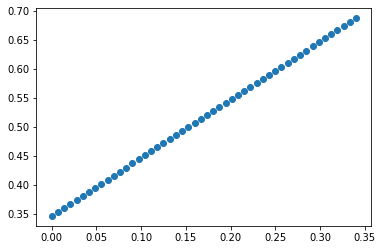

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 1
args.max_num_objects = 2

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
print(states)

plt.scatter(x,y)

Next, we will look at multiple objects. This shows that any trajectory with the offset we're using still passes through the center. If we wanted we could add an additional offset, as there will be association confusion when passing through the center. 

Initializing DataGenerator with movement type  MovementType.Linear2D
torch.Size([50, 80])
torch.Size([50, 80])
torch.Size([100, 80])


Text(0.5, 1.0, 'No offset')

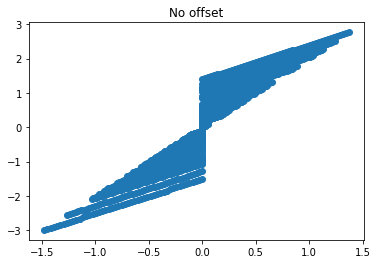

In [49]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_frames = 100
args.expected_num_objects = 80
args.max_num_objects = 101

#assume linear 2D motion
num_dimensions = 2
dataGenerator = DataGenerator(MovementType.Linear2D)
num_objects = int(round(args.expected_num_objects))  
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
dynamics = dataGenerator.get_dynamics(args.num_frames)
positions = dynamics.mm(states.t())

x = positions[:50]
y = positions[50:]
print(y.shape)
print(x.shape)
print(positions.shape)
#print(states)

plt.scatter(x,y,cmap='jet')
plt.title("No offset")

Now I add an offset, and I'll plot a few lines so we can see them over the distribution.

torch.Size([100, 80])
torch.Size([80, 1])


Text(0.5, 1.0, 'With offset')

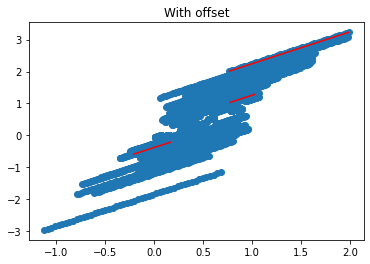

In [69]:
offsets = dist.Uniform(0., 1.).sample((args.expected_num_objects,1))
dynamics = dataGenerator.get_dynamics(args.num_frames)
states = dist.Normal(0., 1.).sample((num_objects, num_dimensions))
positions = dynamics.mm(states.t())
positions = positions + offsets.t()

print(positions.shape)
print(offsets.shape)

x = positions[:50]
y = positions[50:]


plt.scatter(x,y,cmap='jet')
plt.plot(x[:,0],y[:,0],c='r')
plt.plot(x[:,30],y[:,30],c='r')
plt.plot(x[:,50],y[:,50],c='r')
plt.title("With offset")

X and Y states need to be separated

<h2>Prior Predictive Checks</h2>

To do prior predictive checks I needed to remove the "observations" or the data from the model to be able to check if the model performs acceptably without data. 

To do this, I needed to still have the num_observed, which relies on is_observed which relies on the observations variable. So, I created new variables using the following distributions, which represents a similar method the data would be generated by:
spurious- Poisson
emitted- Bernoulli

is_observed is then obtained from emitted, which is a combination of the Bernoulli distribution of expected observations over a number of frames + spurious observations over a number of frames

In [257]:
def model(args):
    with pyro.plate("objects", args.max_num_objects):
        exists = pyro.sample("exists",
                            dist.Bernoulli(args.expected_num_objects / args.max_num_objects))
        with poutine.mask(mask=exists.bool()):
            states = pyro.sample("states", dist.Normal(0., 1.).expand([args.num_dimensions]).to_event(1))
            positions = dataGenerator.get_dynamics(args.num_frames).mm(states.t())
    with pyro.plate("detections", args.expected_num_objects):
        with pyro.plate("time", args.num_frames):
            spurious = dist.Poisson(args.expected_num_spurious).sample((args.num_frames,1))
            emitted = dist.Bernoulli(args.emission_prob).sample((int(args.num_frames), int(args.expected_num_objects)))
            
            #get the max # of spurious targets in a frame
            maxSpurious = int(max(spurious)[0])
            args.max_num_objects = int(args.expected_num_objects + maxSpurious)
            spuriousVec = np.zeros((args.num_frames, maxSpurious))
            
            #assign 1 or observed for the number of spurious observations per frame
            count = 0
            for i in spurious:
                spuriousVec[count,0:int(i[0])] = 1
                count = count + 1
                
            print("Emitted shape before: ", emitted.shape)
            print(emitted)
            #combine the emitted with the spurious observations
            emitted = torch.cat((emitted,torch.tensor(spuriousVec)), 1)
            print("Emitted shape after: ", emitted.shape)
            print(emitted)

            #add assignment IDs for each of the observations
            is_observed = (emitted > 0)
            print("Max number of objects: ", args.max_num_objects)
            print("is_observed shape: ", is_observed.shape)
            print(is_observed)
            with poutine.mask(mask=is_observed):
                assign = pyro.sample("assign",
                                    dist.Categorical(torch.ones(args.max_num_objects)))
            
            print("Assign before, ", assign.shape, assign)
            allZerosSpurious = torch.tensor(np.zeros((args.num_frames, maxSpurious),dtype=int))
            assign = torch.cat((assign, allZerosSpurious), 1)
            print("Assign after, ", assign)
            is_spurious = np.zeros(emitted.shape, dtype=bool)
            is_spurious[:,int(args.expected_num_objects):] = (spuriousVec).astype(bool)
            is_spurious = torch.tensor(is_spurious)
            is_real = is_observed & ~is_spurious
            num_observed = is_observed.float().sum(-1, True)

            bernoulliRealProbs = args.expected_num_objects / num_observed
            bernoulliRealProbs = np.clip(bernoulliRealProbs, 0., 1.)
            isReal = pyro.sample("is_real",
                        dist.Bernoulli(bernoulliRealProbs))

            bernoulliSpuriousProbs = args.expected_num_spurious / num_observed
            bernoulliSpuriousProbs = np.clip(bernoulliSpuriousProbs, 0., 1.)
            isSpurious = pyro.sample("is_spurious",
                        dist.Bernoulli(bernoulliSpuriousProbs))

            # The remaining continuous part is exact.
            with poutine.mask(mask=is_real):
                bogus_position = positions.new_zeros(args.num_frames, maxSpurious-1)
                augmented_positions = torch.cat([positions, bogus_position], -1)
                
                predicted_positions = gather(augmented_positions, assign, -1)
                real = pyro.sample("real_observations",
                            dist.Normal(predicted_positions, args.emission_noise_scale))
            with poutine.mask(mask=is_spurious):
                spurious = pyro.sample("spurious_observations", dist.Normal(0., 1.))
            return isReal, isSpurious, real, spurious

In [258]:
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2
isReal, isSpurious, real_observations, spurious_observations = model(args)
print("Is Real Mask: ")
print(isReal)
print("Is Spurious Mask: ")
print(isSpurious)
print("Real Observations: ")
print(real_observations)
print("Spurious Observations: ")
print(spurious_observations)


Emitted shape before:  torch.Size([5, 3])
tensor([[1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])
Emitted shape after:  torch.Size([5, 6])
tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 0., 0.]], dtype=torch.float64)
Max number of objects:  6
is_observed shape:  torch.Size([5, 6])
tensor([[ True,  True, False, False, False, False],
        [ True,  True,  True, False, False, False],
        [ True,  True,  True,  True, False, False],
        [False, False,  True,  True,  True,  True],
        [False, False,  True,  True, False, False]])
Assign before,  torch.Size([5, 3]) tensor([[0, 0, 2],
        [3, 4, 2],
        [5, 1, 2],
        [2, 0, 5],
        [5, 0, 0]])
Assign after,  tensor([[0, 0, 2, 0, 0, 0],
        [3, 4, 2, 0, 0, 0],
        [5, 1, 2, 0, 0, 0],
        [2, 0, 5, 0, 0, 0],
        [5, 0, 0, 0, 0, 0]])
I

As you can see we need to normalize, and be able to produce many samples so we can visualize what distribution this model represents for spurious vs real objects being detected, especially if we modify the emission probability and the expected number of spurious returns. 

In [259]:
def normalize_tensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

normalizedReal = normalize_tensor(real_observations)
print(normalizedReal)

normalizedSpurious = normalize_tensor(spurious_observations)
print(normalizedSpurious)

tensor([[0.3604, 0.3560, 0.2831],
        [0.0886, 0.0000, 0.1155],
        [0.4096, 0.2720, 0.3205],
        [1.0000, 0.7848, 0.7215],
        [0.1101, 0.2251, 0.2842]])
tensor([[0.7267, 0.8396, 0.8267],
        [0.0000, 1.0000, 0.7736],
        [0.4546, 0.5202, 0.4353],
        [0.9986, 0.2220, 0.9743],
        [0.8368, 0.8984, 0.5958]])


In [260]:
# For the binary "Real" and "Spurious" masks returns a vector of ratios that are real or spurious for each sample
# For the normalized "Real" and "Spurious" likelihoods returns a vector of all scenarios concatted together
# These can be used to acquire a mean and stddev and be plotted to see the distributions
def getManySamples(args, number_of_samples):
    numReal = []
    numSpurious = []

    allNormalizedReal = torch.tensor([])
    allNormalizedSpurious = torch.tensor([])

    for i in range(number_of_samples):
        isReal, isSpurious, real_observations, spurious_observations = model(args)

        normalizedReal = normalize_tensor(real_observations)
        normalizedSpurious = normalize_tensor(spurious_observations)

        #add ratio of real and spurious
        numReal.append(torch.sum(isReal)/torch.numel(isReal))
        numSpurious.append(torch.sum(isSpurious)/torch.numel(isSpurious))

        #Accumulating all percentages from all samples so we can compute a mean and stddev
        allNormalizedReal = torch.cat((allNormalizedReal, normalizedReal),1)
        allNormalizedSpurious = torch.cat((allNormalizedSpurious, normalizedSpurious),1)

    return numReal, numSpurious, allNormalizedReal, allNormalizedSpurious

def getStatsAndPlotCount(numReal, numSpurious, ax, args):
    numRealMean = np.mean(np.array(numReal))
    numRealStddev = np.std(np.array(numReal))
    print("Num real mean: ", numRealMean, " stddev: ", numRealStddev)

    ax[0].plot(numReal, norm.pdf(numRealMean, numRealStddev), 'g')

    numSpuriousMean = np.mean(np.array(numSpurious))
    numSpuriousStddev = np.std(np.array(numSpurious))
    print("Num real mean: ", numSpuriousMean, " stddev: ", numSpuriousStddev)

    ax[0].plot(numSpurious, norm.pdf(numSpuriousMean, numSpuriousStddev), 'r')

def getStatsAndPlotNormalized(allNormalizedReal, allNormalizedSpurious, ax, args):
    normRealSum = torch.sum(allNormalizedReal)
    normRealMean = normRealSum/torch.numel(allNormalizedReal)

    realTitle = "Real, emissionProb: " + str(args.emission_prob)
    ax[1].plot(allNormalizedReal, norm.pdf(normRealMean, torch.var(allNormalizedReal), unbiased=False), 'g', label=realTitle)

    normSpuriousSum = torch.sum(allNormalizedSpurious)
    normSpuriousMean = normSpuriousSum/torch.numel(allNormalizedSpurious)

    spuriousTitle = "Spurious, expected: " + str(args.expected_num_spurious)
    ax[1].plot(allNormalizedSpurious, norm.pdf(normSpuriousMean, torch.var(allSpurious, unbiased=False)), 'r', label=spuriousTitle)


Running variation with: 
Emission Probability:  0.8
Expected Number of Spurious:  1.0
Emitted shape before:  torch.Size([5, 3])
tensor([[1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [0., 1., 1.]])
Emitted shape after:  torch.Size([5, 5])
tensor([[1., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 0.]], dtype=torch.float64)
Max number of objects:  5
is_observed shape:  torch.Size([5, 5])
tensor([[ True,  True, False,  True, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True, False],
        [False,  True,  True,  True, False]])
Assign before,  torch.Size([5, 3]) tensor([[3, 0, 0],
        [1, 0, 2],
        [3, 3, 2],
        [3, 1, 4],
        [0, 1, 0]])
Assign after,  tensor([[3, 0, 0, 0, 0],
        [1, 0, 2, 0, 0],
        [3, 3, 2, 0, 0],
        [3, 1, 4, 0, 0],
        [0,

RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 1

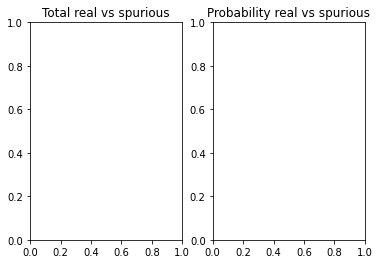

In [261]:

def runPriorPredictiveChecks(args, ax, emissionColor, spuriousColor):
    print("Running variation with: ")
    print("Emission Probability: ", args.emission_prob)
    print("Expected Number of Spurious: ", args.expected_num_spurious)
    numReal, numSpurious, allNormalizedReal, allNormalizedSpurious = getManySamples(args, 1000)
    getStatsAndPlotCount(numReal, numSpurious, ax, args, emissionColor, spuriousColor)
    getStatsAndPlotNormalized(allNormalizedReal, allNormalizedSpurious, ax, args,  emissionColor, spuriousColor)
    
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2

#set up plotting
fig, ax = plt.subplots(1,2)
ax[0].set_title('Total real vs spurious')
ax[1].set_title('Probability real vs spurious')

#run default arguments
runPriorPredictiveChecks(args, ax, 1.0, 1.0)
ax[0].legend(shadow=True, fancybox=True)
ax[1].legend(shadow=True, fancybox=True)
plt.show()

Running variation with: 
Emission Probability:  0.4
Expected Number of Spurious:  0.0


ValueError: The parameter rate has invalid values

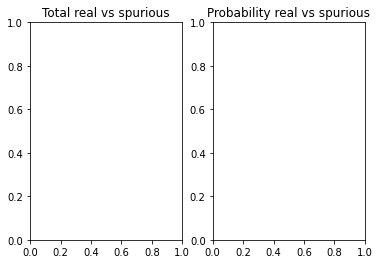

In [256]:
#run the variation changing the emission probability and the expected number of spurious observations
emissionProbs = [0.4, 0.6, 0.8, 1.0]
expectedSpurious = [0., 1., 2.]

emissionColors = [0.25, 0.5, 0.75, 1.0]
spuriousColors = [0.33, 0.66, 1.0]

#set up plotting
fig, ax = plt.subplots(1,2)
ax[0].set_title('Total real vs spurious')
ax[1].set_title('Probability real vs spurious')

#setting initial args, but we'll be overwriting two of them through the loop
argsObj = Args()
args = argsObj.get_default_args()
args.num_dimensions = 2

emCount = 0
spCount = 0
for em in emissionProbs:
    args.emission_prob = em
    emColor = emissionColors[emCount]
    for sp in expectedSpurious:
        spColor = spuriousColors[spCount]
        args.expected_num_spurious = sp
        runPriorPredictiveChecks(args, ax, emColor, spColor)
        spCount = spCount + 1
    emCount = emCount + 1

ax[0].legend(shadow=True, fancybox=True)
ax[1].legend(shadow=True, fancybox=True)
plt.show()